# INDIV high emittance high intensity beam
- PSB: INDIV_HI_HE
- PS: INDIV_CLONE

#### Annotations:
1. **Intensity** fluctuation looks negligible, apart for just after the injection, the intensity oscillates in the flat bottom between 24 and 27 *10^10 protons per bunch
2. For once, the **BPMs** logged everyhing they are supposed to
3. Two bad shots removed, were crashing the wire scanner analysis routine

In [56]:
%run /eos/project/m/mte/Toolbox/myToolbox.py
print '---'
%run /eos/user/e/esenes/PS-analysis-tools/eTools.py

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.
Your platform is Linux-3.10.0-693.2.2.el7.x86_64-x86_64-with-redhat-6.9-Carbon
Your folder is /eos/user/e/esenes/Injection_missteering/2017.10.11
Your IP is 172.17.0.3
2017-11-01 21:33:42
---


In [57]:
# let's start with the matlab data
files = sorted(glob.glob('/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/data/2017*.mat'))
print 'Found ' + str(len(files)) + ' data files'
print 'First: ' + files[0]
print 'End: ' + files[-1]

Found 235 data files
First: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/data/2017.10.11.16.02.52.984.mat
End: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/data/2017.10.11.19.04.11.158.mat


## Load the data

In [58]:
myDataFrame = myToolbox.fromMatlabToDataFrame(files,['PR_BWS_54_H_ROT.Acquisition.value.projDataSet1','PR_BWS_54_H_ROT.Acquisition.value.projPositionSet1',
                                                     'PR_BWS_85_V_ROT.Acquisition.value.projDataSet1','PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1',
                                                         'logical_PI_KFA45.K.value',
                                                     'PR_BPM.AcquisitionOrbit.value.position',
                                                    'PR_BPM.AcquisitionTrajectoryBBB.value.position',
                                                    'PR_BCT_ST.Samples.value.samples','PI_KFA45.AQN1.value'],verbose=False)                                                        

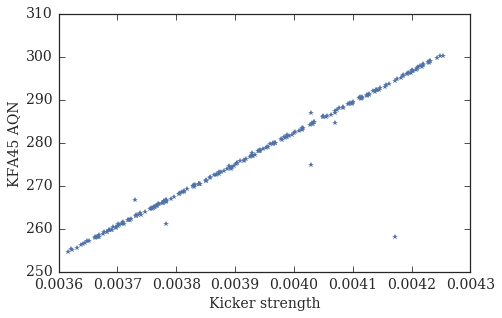

In [59]:
shiftVal=1
plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['PI_KFA45.AQN1.value'],'*')
plt.xlabel('Kicker strength')
plt.ylabel('KFA45 AQN')

In [60]:
# data cleanup, drop duplicates keeping the first acquisition
myDataFrame = myDataFrame.drop_duplicates(['cycleStamp'],keep='first')

## Intensity

In [61]:
myDataFrame['Intensity'] = myDataFrame['PR_BCT_ST.Samples.value.samples']
myDataFrame['Losses_perc'] = myDataFrame['Intensity'].apply(lambda x: 1-x[:][600]/np.max(x) )

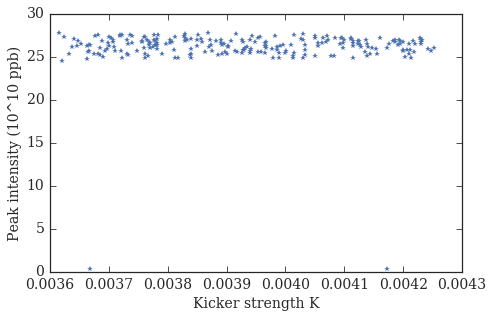

In [62]:
plt.plot(myDataFrame['logical_PI_KFA45.K.value'],myDataFrame['Intensity'].apply(lambda x: np.max(x)),'*')
plt.xlabel('Kicker strength K')
plt.ylabel('Peak intensity (10^10 ppb)')
#plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')

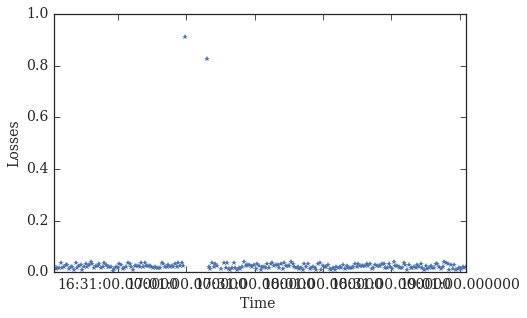

In [63]:
plt.plot(myDataFrame['Losses_perc'],'*')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,1))
plt.xlabel('Time ')
plt.ylabel('Losses')

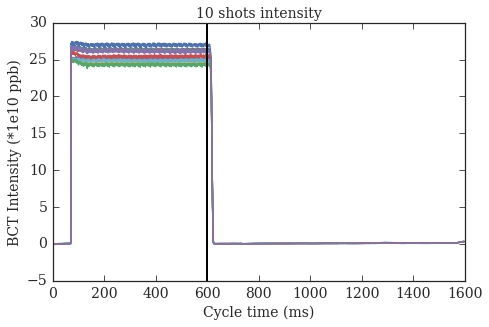

In [64]:
for ll in range(10):
    plt.plot(myDataFrame['Intensity'].values[ll])
    
plt.axvline(x=600, ymin=0, ymax = 8, linewidth=2, color='k')
plt.xlabel('Cycle time (ms)')
plt.ylabel('BCT Intensity (*1e10 ppb)')
plt.title('10 shots intensity')

## BPMs

In [65]:
# BPMs
#add field for the first two turns and splitting x and y pickups
myDataFrame['BPMx_turn1'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[0:43,0])
myDataFrame['BPMy_turn1'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[-43:,0])
myDataFrame['BPMx_turn2'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[0:43,1])
myDataFrame['BPMy_turn2'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[-43:,1])
# #turn to millimiters and cast in float
myDataFrame['BPMx_turn1'] = myDataFrame['BPMx_turn1'].apply(lambda x: x/10.)
myDataFrame['BPMy_turn1'] = myDataFrame['BPMy_turn1'].apply(lambda x: x/10.)
myDataFrame['BPMx_turn2'] = myDataFrame['BPMx_turn2'].apply(lambda x: x/10.)
myDataFrame['BPMy_turn2'] = myDataFrame['BPMy_turn2'].apply(lambda x: x/10.)
# #add orbit
myDataFrame['Orbit_x'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: x[0:43,1])
myDataFrame['Orbit_y'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: x[-43:,1])
myDataFrame['Orbit_x'] = myDataFrame['Orbit_x'].apply(lambda x: x/10.)
myDataFrame['Orbit_y'] = myDataFrame['Orbit_y'].apply(lambda x: x/10.)

Kick: 0.003693


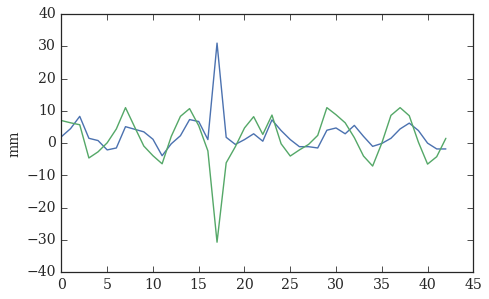

In [66]:
idx = 100

print 'Kick: '+str(myDataFrame['logical_PI_KFA45.K.value'].values[idx])

plt.plot(myDataFrame['BPMx_turn1'].values[idx])
plt.plot(myDataFrame['BPMx_turn2'].values[idx])

plt.ylabel('mm')

plt.show()

## Calculate the RMS orbit deviation
Use difference between the first and second turn to evaluate the orbit deviation from the reference orbit, where


$$\Delta x_\text{rms} =  \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_\text{turn2} - x_\text{turn1})^2 }$$


excluding the BPM in the bump, that would dominate the estimator.

Same for the deviation from the orbit 

$$\Delta x_\text{rms, orbit} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_\text{turn1} - x_\text{average_orbit_1ms})^2 }$$

In [67]:
# X plane
mySeries1 = myDataFrame['BPMx_turn1'].apply(lambda x: np.delete(x,17))
mySeries2 = myDataFrame['BPMx_turn2'].apply(lambda x: np.delete(x,17))
myOrbit = myDataFrame['Orbit_x'].apply(lambda x: np.delete(x,17))

BPM_n = 42;

deltaXrms = []
delta_1st_orbit = []
for x in range(mySeries1.values.size) :
    deltaXrms.append( np.sqrt( ( np.sum((mySeries2.values[x] - mySeries1.values[x])**2) )/BPM_n ) )
    delta_1st_orbit.append( np.sqrt( ( np.sum((mySeries1.values[x] - myOrbit.values[x])**2) )/BPM_n ) )
    
myDataFrame['deltaX_2turns'] = deltaXrms
myDataFrame['OrbitX_dev_RMS'] = delta_1st_orbit

# Y plane
mySeries1 = myDataFrame['BPMy_turn1'].apply(lambda x: np.delete(x,17))
mySeries2 = myDataFrame['BPMy_turn2'].apply(lambda x: np.delete(x,17))
myOrbit = myDataFrame['Orbit_y'].apply(lambda x: np.delete(x,17))

BPM_n = 42;

deltaXrms = []
delta_1st_orbit = []
for x in range(mySeries1.values.size) :
    deltaXrms.append( np.sqrt( ( np.sum((mySeries2.values[x] - mySeries1.values[x])**2) )/BPM_n ) )
    delta_1st_orbit.append( np.sqrt( ( np.sum((mySeries1.values[x] - myOrbit.values[x])**2) )/BPM_n ) )
    
myDataFrame['deltaY_2turns'] = deltaXrms
myDataFrame['OrbitY_dev_RMS'] = delta_1st_orbit

(0.0036000000000000003, 0.0043, 0, 8)

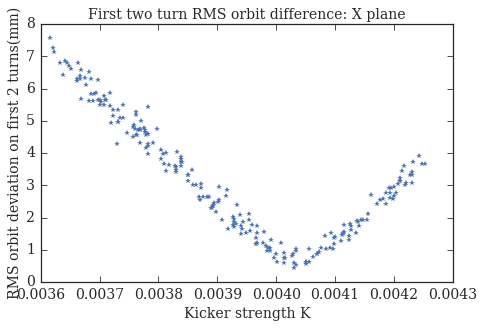

In [68]:
plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['deltaX_2turns'].values,'*')

plt.xlabel('Kicker strength K')
plt.ylabel('RMS orbit deviation on first 2 turns(mm)')
plt.title('First two turn RMS orbit difference: X plane')


x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,8))
# plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')

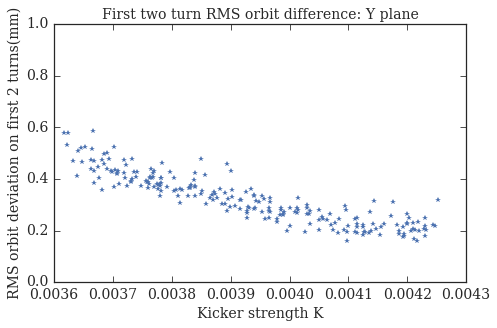

In [69]:
plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['deltaY_2turns'].values,'*')

plt.xlabel('Kicker strength K')
plt.ylabel('RMS orbit deviation on first 2 turns(mm)')
plt.title('First two turn RMS orbit difference: Y plane')

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,1))
plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')

(0.0036000000000000003, 0.0043, 0, 7)

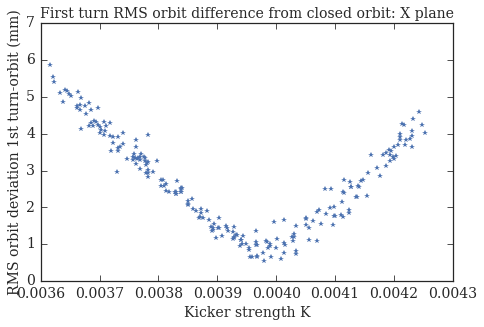

In [70]:
plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['OrbitX_dev_RMS'].values,'*')

plt.xlabel('Kicker strength K')
plt.ylabel('RMS orbit deviation 1st turn-orbit (mm)')
plt.title('First turn RMS orbit difference from closed orbit: X plane')


x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,7))
# plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')

(0.0036000000000000003, 0.0043, 0.2, 0.6)

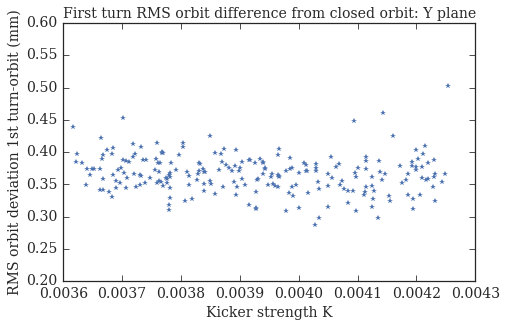

In [71]:
plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['OrbitY_dev_RMS'].values,'*')

plt.xlabel('Kicker strength K')
plt.ylabel('RMS orbit deviation 1st turn-orbit (mm)')
plt.title('First turn RMS orbit difference from closed orbit: Y plane')


x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0.2,0.6))
# plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')

# Injection oscillations

In [72]:
# pickup 21
myDataFrame['BPM_turn1'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[20,:])

# Fittings

In [73]:
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from scipy.optimize import leastsq

In [74]:
# data 
xdata = myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal).values
ydata = myDataFrame['deltaX_2turns'].values

Model function: a+b|x+c|
Fit params: a=0.4 b= 15000.0 c= -0.00404


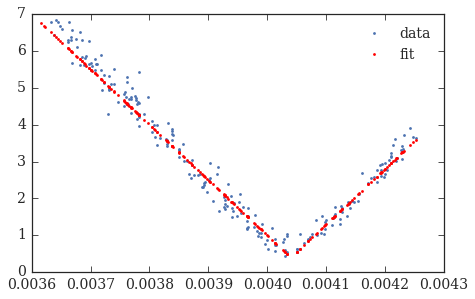

In [75]:
# homemade least square fit
def absFun(x, a, b, c):
    return a + b*np.abs(x+c)

def residual(p, x, y):
    return y - absFun(x, *p)
# initial params
p0 = [0.4, 1.5e4, -0.00404]
# fit
popt, pcov = leastsq(residual, p0, args=(xdata, ydata))

#plot data
plt.plot(xdata, ydata, '.',label='data')

#fit and plot fit
print 'Model function: a+b|x+c|'
print 'Fit params: a=' + str(popt[0]) + ' b= ' + str(popt[1]) + ' c= '+ str(popt[2])
plt.plot(xdata, absFun(xdata, *popt), 'r.', label='fit')

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,7))

plt.legend()

In [76]:
# data 
xdata = myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal).values
ydata = myDataFrame['OrbitX_dev_RMS'].values

Model function: a+b|x+c|
Fit params: a=0.0 b= 30000.0 c= -0.00401


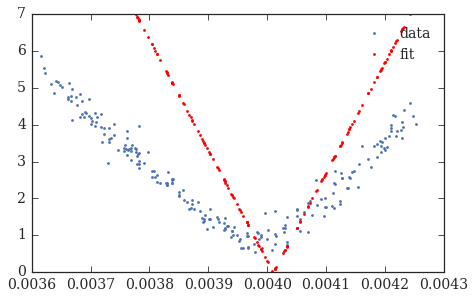

In [77]:
# homemade least square fit
def absFun(x, a, b, c):
    return a + b*np.abs(x+c)

def residual(p, x, y):
    return y - absFun(x, *p)
# initial params
p0 = [0, 3e4, -0.00401]
# fit
popt, pcov = leastsq(residual, p0, args=(xdata, ydata))

#plot data
plt.plot(xdata, ydata, '.',label='data')

#fit and plot fit
print 'Model function: a+b|x+c|'
print 'Fit params: a=' + str(popt[0]) + ' b= ' + str(popt[1]) + ' c= '+ str(popt[2])
plt.plot(xdata, absFun(xdata, *popt), 'r.', label='fit')

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,7))

plt.legend()

## Wire scanner

### X plane

In [78]:
# Wirescanner
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS54_position'] = myDataFrame['PR_BWS_54_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS54_position_idx'] = myDataFrame['PR_BWS_54_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

In [79]:
#instantiate an array object for the result in the frame
myDataFrame['BWS54_data'] = myDataFrame['BWS54_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS54_data'].iloc[r] = np.interp(pos, myDataFrame['BWS54_position'].iloc[r], myDataFrame['PR_BWS_54_H_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS54_position_idx'].iloc[r]])  

In [80]:
#do the fit and get the sigma in mm
myDataFrame['WS_fit_results_x'] = myDataFrame['BWS54_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS_sigma_x'] = myDataFrame['WS_fit_results_x'].apply(lambda x: x[0][-1])

### Y plane

In [81]:
# remove bad shots (cause crash of the fitting)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2017-10-11 17:00:23.500000'].name)
myDataFrame = myDataFrame.drop(myDataFrame.loc['2017-10-11 17:09:55.900000'].name)

In [82]:
# Wirescanner
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS85_position'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS85_position_idx'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

In [83]:
#instantiate an array object for the result in the frame
myDataFrame['BWS85_data'] = myDataFrame['BWS85_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS85_data'].iloc[r] = np.interp(pos, myDataFrame['BWS85_position'].iloc[r], myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS85_position_idx'].iloc[r]])  

In [84]:
# data cleanup check
# for k in range(231):
#     plt.plot(myDataFrame['BWS85_data'].values[k])
#     if max(myDataFrame['BWS85_data'].values[k]) < 0.2:
#         print k

In [85]:
#do the fit and get the sigma in mm
myDataFrame['WS_fit_results_y'] = myDataFrame['BWS85_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS_sigma_y'] = myDataFrame['WS_fit_results_y'].apply(lambda x: x[0][-1])

### Tomogram

In [86]:
myDataFrame['deltaP_P_rms']=5.94e-4
myDataFrame['peakLineDensity']=0.58

## Emitance

In [87]:
def normalised_emittance(sig, dp):
    "Calculate the normalised emittance, where sig is in mm. dp is DeltaP/P rms"
    betar = 0.915095 
#     D = 2.330216464 #at wirescanner 68
#     D = 3.24577470 #at wirescanner 65
    D = 2.27815054 #at wirescanner 54
#     betax = 13.00860302 #at wirescanner 68
#     betax = 21.77988929 #at wirescanner 65
    betax = 12.45331755 #at wirescanner 54
    
    gammar = 1/ np.sqrt(1-betar**2)
    
    #normalised emittance
    emi = ((sig*1e-3)**2 - D**2*dp**2)/betax *(betar*gammar)
    return emi*1e6

def normalised_emittance_y(sig):
    "Calculate the normalised emittance without the dispesive component"
    betar = 0.915095
    betay = 11.44763004 #[metres] #at wirescanner 85
    gammar = 1/ np.sqrt(1-betar**2)
    
    #normalised emittance
    emi = ((sig*1e-3)**2)/betay *(betar*gammar)
    return emi*1e6
    

### Y plane

In [88]:
myDataFrame['WS_emittance_y'] = myDataFrame['WS_sigma_y'].apply(lambda x: normalised_emittance_y(x))

In [89]:
# plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['WS_emittance_y'],'.')
# plt.xlabel('Kicker strength K (arb.u.)')
# plt.ylabel('Normalised emittance (mm.mrad)')
# # plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')
# x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,.4,2))
# # IMPORTANT NOTE: the gaussian smears out at low kicker strenghts --> error on the emittance is bigger 

### X plane

In [90]:
myDataFrame['WS_emittance_x'] = np.nan

for n in range(len(myDataFrame)):
    myDataFrame['WS_emittance_x'].iloc[n] = normalised_emittance(myDataFrame['WS_sigma_x'].values[n],myDataFrame['deltaP_P_rms'].values[n])

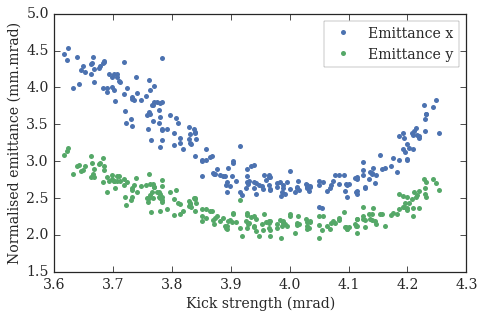

In [93]:
fig, ax = plt.subplots(1)
ax.plot(1e3*myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['WS_emittance_x'],'.',label='Emittance x',markersize=10)
plt.xlabel('Kick strength (mrad)')
plt.ylabel('Normalised emittance (mm.mrad)')
# plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')
# set axis to get rid of some bad shots
# x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1.5,5.5))


ax.plot(1e3*myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['WS_emittance_y'],'.',label='Emittance y',markersize=10)

legend = plt.legend(frameon=True)

plt.show()

fig.savefig('INDIV_HI_HE_emi_xy.eps', format='eps')

## Comparison to theory

Model function: a(x - b)^2 + c
Fit params: a=13.5866140878 b= 0.00401359068411 c= 2.69736508624e-06


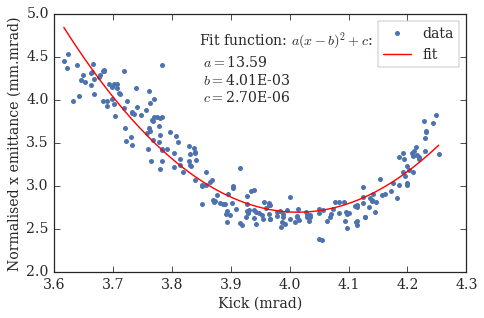

In [94]:
from scipy.optimize import curve_fit

def f_to_fit(x, a, b, c):
    return a*(x - b)**2 + c

xdata = myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal)[1:]
ydata = 1e-6*myDataFrame['WS_emittance_x'].values[1:]

fig, ax = plt.subplots(1)
ax.plot(1e3*xdata, 1e6*ydata,'.',label='data', markersize=10) #factors are to adjust units in the plot

p, cov = curve_fit(f_to_fit,xdata,ydata)

xfit = np.linspace(np.min(xdata),np.max(xdata),200)
ax.plot(1e3*xfit, 1e6*f_to_fit(xfit, *p), 'r-', label='fit') #factors are to adjust units in the plot

#fit and plot fit
print 'Model function: a(x - b)^2 + c'
print 'Fit params: a=' + str(p[0]) + ' b= ' + str(p[1]) + ' c= '+ str(p[2])


plt.xlabel('Kick (mrad)')
plt.ylabel('Normalised x emittance (mm.mrad)')
plt.legend(frameon=True)

ax.text(0.35, 0.95, 'Fit function: $a(x-b)^2+c$:\n $a=$%.2f \n $b=$%.2E \n $c=$%.2E'%(p[0],p[1],p[2]),
        transform=ax.transAxes, fontsize=14,verticalalignment='top')

fig.savefig('INDIV_HI_HE_emi_x_fitted.eps', format='eps')

## Laslett tune shift

In [38]:
# brightness and intensity
myDataFrame['WS_intensity'] = myDataFrame['Intensity'].apply(lambda x: x[80])
myDataFrame['Brightness'] = myDataFrame['WS_intensity']/(0.5*(myDataFrame['WS_emittance_x']+myDataFrame['WS_emittance_y']))

In [39]:
twiss_file_name = '/eos/user/e/esenes/AnalysisTools/Injection7_optics_Qx_0.21_Qy_0.23_cycled_timefalse.outx'

[deltaQx, deltaQy] = laslett_sc_PS(myDataFrame['peakLineDensity'], myDataFrame['deltaP_P_rms'],
              1e-6*myDataFrame['WS_emittance_x'], 1e-6*myDataFrame['WS_emittance_y'],
              1400, twiss_file_name)

myDataFrame['deltaQx'] = deltaQx
myDataFrame['deltaQy'] = deltaQy

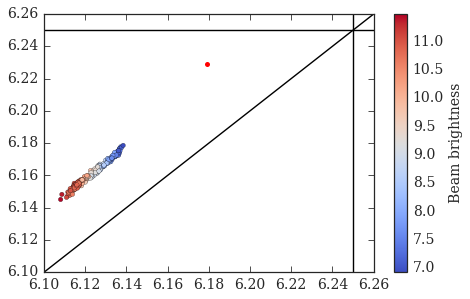

In [40]:
fig, ax = plt.subplots(1)

# working point
Qx = 6.179
Qy = 6.229
plt.plot(Qx,Qy,'r.',markersize=10)

# tune diagram lines
ax.plot([5.8, 6.3],[5.8, 6.3],'k')
ax.plot([6, 6],[5.8, 6.3],'k')
ax.plot([5.8, 6.3],[6, 6],'k')
ax.plot([6.25, 6.25],[5.8, 6.3],'k')
ax.plot([5.8, 6.3],[6.25, 6.25],'k')
# options
plt.xlim([6.1, 6.26])
plt.ylim([6.1, 6.26])
# tune shifts


p1 = ax.scatter(Qx+myDataFrame['deltaQx'], Qy+myDataFrame['deltaQy'], c=myDataFrame['Brightness'], cmap=plt.cm.coolwarm)
clb = fig.colorbar(p1)
clb.set_label('Beam brightness')

plt.show()

fig.savefig('INDIV_HI_HE_footprint.eps', format='eps')

Shifted x tune threshold < 6.179
Shifted y tune threshold < 6.229


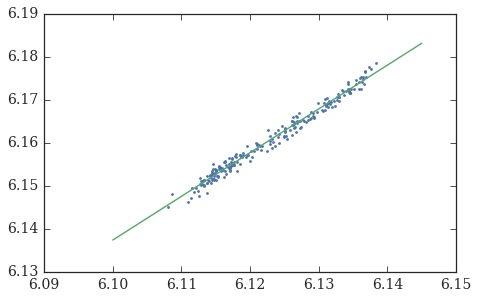

In [41]:
# linear fitting of the data
Qx_thr = -0
Qy_thr = -0
print 'Shifted x tune threshold < '+str(Qx+Qx_thr)
print 'Shifted y tune threshold < '+str(Qy+Qy_thr)

dQx = Qx + myDataFrame['deltaQx'].loc[(myDataFrame['deltaQx'] < Qx_thr) & (myDataFrame['deltaQy'] < Qy_thr)]
dQy = Qy + myDataFrame['deltaQy'].loc[(myDataFrame['deltaQx'] < Qx_thr) & (myDataFrame['deltaQy'] < Qy_thr)]
plt.plot(dQx,dQy,'.')

# the fit
param = np.polyfit(dQx,dQy,1)
x = np.linspace(6.1,6.145,100)
plt.plot(x,param[0]*x+param[1])


In [42]:
param

print "multiplying by 17 it is: 17.3Qx - 17Qy = 1.07"
print "-or- multiplying by 20 it is: 20Qx - 20Qy = 1, (very rough)"

multiplying by 17 it is: 17.3Qx - 17Qy = 1.07
-or- multiplying by 20 it is: 20Qx - 20Qy = 1, (very rough)


## Emittance with dispersive profile deconvolution calculation

In [43]:
# directly copied from one of Guido's analyses
def extractProfile(fileName):
    '''Give me the input file (.dat) of the tomogram and I will give you 2 output:
        the deltaP_P and the the momentum distribution profile.
    ''' 

    print('/eos/project/l/liu/Instrumentation/tomography/runofflinetomo ' + fileName)
    a=os.system('/eos/project/l/liu/Instrumentation/tomography/runofflinetomo ' + fileName)
    
    convergence=np.loadtxt(fileName[0:-4] + '/d001.data')
    image=np.loadtxt(fileName[0:-4] + '/image001.data')
    with open(fileName[0:-4] + '/input_v2.dat','r') as stream: tomofileheader = stream.readlines()[:98]

    myInput={'PLSUSER': tomofileheader[0][0:-1],
            'NumberOfframes': np.int(tomofileheader[16][0:-1]),
            'B_T': np.double(tomofileheader[75][0:-1]),
            'Bdot_T_per_s': np.double(tomofileheader[77][0:-1]),
            'machineRadius_m': np.double(tomofileheader[79][0:-1]),
            'bendingRadius_m': np.double(tomofileheader[81][0:-1]),
            'particleMass_eV': np.double(tomofileheader[85][0:-1]),
            'h': np.int(np.double(tomofileheader[69][0:-1])),
            'ctime': np.int(tomofileheader[2]),
            'cycleStamp':np.int(tomofileheader[1]),                    # cyclestamp in unix time
            'pickupSensitivity':np.double(tomofileheader[97])          # pickup sensitivity
    }

    with open(fileName[0:-4] + '/plotinfo.data','r') as stream: tomofileheader = stream.readlines()

    myInput['profilecount']=np.int(str.split(tomofileheader[1])[2])
    myInput['profilelength']=np.int(str.split(tomofileheader[3])[2])

    myInput['dtbin']=np.double(str.split(tomofileheader[5])[2])
    myInput['dEbin']=np.double(str.split(tomofileheader[7])[2])
    myInput['xat0']=np.double(str.split(tomofileheader[11])[2])
    myInput['yat0']=np.double(str.split(tomofileheader[12])[2])
    myInput['eperimage']=np.double(str.split(tomofileheader[9])[2])

    mySpeedOfLight=299792458. #TODO
    myInput['momentum_eV']=myInput['B_T']*myInput['bendingRadius_m']/(10/mySpeedOfLight*1e8)*1.e9 #TODO
    myInput['totalEnergy_eV']=np.sqrt(myInput['momentum_eV']**2+myInput['particleMass_eV']**2)
    myInput['gamma']=myInput['totalEnergy_eV']/myInput['particleMass_eV']
    myInput['beta']=np.sqrt(1-1/myInput['gamma']**2)

    image=image*myInput['eperimage']/myInput['dtbin']/myInput['dEbin']

    halfProfileLength=myInput['profilelength']/2.

    Toffset= (myInput['xat0']-halfProfileLength)*myInput['dtbin']*1e9
    Eoffset= (myInput['yat0']-halfProfileLength)*myInput['dEbin']/1e6

    t=np.arange(-halfProfileLength,halfProfileLength)*myInput['dtbin']*1e9-Toffset
    E=np.arange(-halfProfileLength,halfProfileLength)*myInput['dEbin']/1e6-Eoffset


    deltaP_P= 1/myInput['beta']**2*E*1e6/myInput['totalEnergy_eV']
    myProfile=np.sum(np.reshape(image, [myInput['profilelength'], myInput['profilelength']]),0)
    myProfile=myProfile/np.trapz(myProfile,deltaP_P)
    myInput['deltaP_P']=deltaP_P;
    myInput['myProfile']=myProfile;
    myInput['E_MeV']=E
    myInput['t_ns']=t
    myInput['phaseSpace_e_per_eVs']=np.reshape(image, [myInput['profilelength'], myInput['profilelength']]);
    myProfileNormalized=myProfile/np.trapz(myProfile,deltaP_P)
    myMean=np.trapz(deltaP_P*myProfileNormalized,deltaP_P)
    myRMS=np.sqrt(np.trapz((deltaP_P-myMean)**2*myProfileNormalized,deltaP_P))
    myInput['deltaP_P_RMS']=myRMS
    return myInput

In [44]:
# new tomogram analysis
files_tomo=sorted(glob.glob('/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/tomo_data/*.dat'))
tomo_data = pnd.DataFrame()

for f in range(len(files_tomo)):
    try:
        tomo_d = extractProfile(files_tomo[f])
        tomo_d['Filename'] = files_tomo[f]
        if tomo_d is np.nan:
            pass
        else:
            tomo_data=tomo_data.append(tomo_d,ignore_index=True)
    except IOError:
        print '\nIOError\n'

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/tomo_data/autosave_486.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/tomo_data/autosave_487.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/tomo_data/autosave_488.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/tomo_data/autosave_489.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/tomo_data/autosave_490.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/tomo_data/autosave_491.dat
/eos/project/l/liu/Ins

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/tomo_data/autosave_537.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/tomo_data/autosave_538.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/tomo_data/autosave_539.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/tomo_data/autosave_540.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/tomo_data/autosave_541.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/tomo_data/autosave_542.dat
/eos/project/l/liu/Ins

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/tomo_data/autosave_588.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/tomo_data/autosave_589.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/tomo_data/autosave_590.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/tomo_data/autosave_591.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/tomo_data/autosave_592.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/tomo_data/autosave_593.dat
/eos/project/l/liu/Ins

/cvmfs/sft.cern.ch/lcg/views/LCG_91/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/numpy/lib/npyio.py:893: UserWarning: loadtxt: Empty input file: "/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/tomo_data/autosave_631/d001.data"
  warnings.warn('loadtxt: Empty input file: "%s"' % fname)


/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/tomo_data/autosave_633.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/tomo_data/autosave_634.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/tomo_data/autosave_635.dat

IOError

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/tomo_data/autosave_636.dat

IOError

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/tomo_data/autosave_637.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/tomo_data/autosave_638.dat
/e

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/tomo_data/autosave_683.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/tomo_data/autosave_684.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/tomo_data/autosave_685.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/tomo_data/autosave_686.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/tomo_data/autosave_687.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/tomo_data/autosave_688.dat
/eos/project/l/liu/Ins

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/tomo_data/autosave_736.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/tomo_data/autosave_737.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/tomo_data/autosave_738.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/tomo_data/autosave_739.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/tomo_data/autosave_740.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.10.11/tomo_data/autosave_741.dat

IOError

/eos/project

In [47]:
timeTolerance = 35

# ----------
myDataFrame['tomoTimestamp']=np.nan
myDataFrame['tomoDelta']=np.nan
myDataFrame['tomoFilename']=np.str

succ_count = 0
last_match = 0
# loop over the tomo_timestamps
for k in range(len(tomo_data)):
    tomo_local_cs = tomo_data['cycleStamp'].values[k]
    t = myToolbox.unixtime2datetime(tomo_local_cs)
    tomo_fname = tomo_data['Filename'].iloc[k]

    # loop over the matlab data
    for x in range(len(myDataFrame)):
        c = myToolbox.unixtime2utcdatetime(myDataFrame['cycleStamp'].values[x]*1e-9)
        d = t-c
        d = d.total_seconds()

        if np.abs(d) <= timeTolerance and x > last_match: #avoid match the same tomogram to more matlab acquisition unintentionally
            myDataFrame['tomoTimestamp'].iloc[x] = tomo_local_cs
            myDataFrame['tomoFilename'].iloc[x] = tomo_fname
            myDataFrame['tomoDelta'].iloc[x] = d


            succ_count += 1 #dummy counter
            
print str(succ_count) +"/"+ str(len(tomo_data)) +" are within the timeTolerance"
print 'length of dataframe is: '+ str(len(myDataFrame)) 

0/243 are within the timeTolerance
length of dataframe is: 230


In [ ]:
tomo_data

In [46]:
# discard the elements without tomogram (are probably double shots of matlab)
discFlag = np.isnan(myDataFrame['tomoDelta'].values)
myDataFrame = myDataFrame.drop(myDataFrame.loc[discFlag].index)

In [47]:
### SLOW METHOD, processes twice
myDataFrame['momentumProfile']=myDataFrame['tomoFilename'].apply(extractProfile)

In [48]:
# BWS65
betax = 21.77988929
Dx = 3.24577470
betar = 0.915095
gammar = 2.47992305234

def deconv_caller(row):
    return myToolbox.computeTransverseEmittance(row['PR_BWS_54_H_ROT.Acquisition.value.projPositionSet1'],
                              row['PR_BWS_54_H_ROT.Acquisition.value.projDataSet1'],
                              row['momentumProfile']['myProfile'],
                              row['momentumProfile']['deltaP_P'],
                              row['momentumProfile']['beta']*row['momentumProfile']['gamma'],
                              betaOptical_m=betax,Dispersion_m=Dx)

myDataFrame['Deconvolution_result'] = myDataFrame.apply(deconv_caller,axis=1)



for k in myDataFrame.index:  
    myDataFrame.loc[k,'Emittance_x_deconv'] = myDataFrame.loc[k,('Deconvolution_result')]['emittance_um']


ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

In [ ]:
plt.plot(myDataFrame['WS_emittance_x'],myDataFrame['Emittance_x_deconv'],'.')
plt.xlabel('Wirescanner measurement')
plt.ylabel('Deconvoluted normalised emittance')

plt.plot([1,3],[1,3],'-k')
x1,x2,y1,y2 = plt.axis()
plt.axis((1,2.5,1,2.5))

## Export the data

In [ ]:
myDataFrame[['logical_PI_KFA45.K.value','peakLineDensity','WS_emittance_x','WS_emittance_y','deltaP_P_rms','WS_intensity']].to_csv('dataFrameExported.csv')